<h1>Data presentation script

<h2>Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

<h3>Fundamental functions

In [167]:
pd.set_option("mode.chained_assignment", None)

def getChromossome(df, n):
    """Returns pandas dataframe with only the citobands of one chromossome n
    """
    chomossome = str(n)
    chr_array = []
    #print("dataframe columns = ", df.columns)
    #chr_array.append(['Chromossome','First_index', 'Last_index', "Citoband", 'Unkown'])
    for row in df.values:
        cito_array = []
        if row[0] == chomossome:
            for col in row:
                cito_array.append(col)
            chr_array.append(cito_array)
    return pd.DataFrame(chr_array, columns=df.columns)


def createLabels(citobands, str_dens):
    labels = citobands.values
    for i in range(len(str_dens.values)):
        if str_dens[i] <= 0.1:
            labels[i] = " "
    return labels
    

def plotAll(cb_df):
    figure, axis = plt.subplots(8, 3, figsize=(72,80))
    chromossomes = cb_df["Chromossome"].unique()
    chromossomes = list(map(str, chromossomes))
    chromossomes.remove("chrM")
    chr_n = 0
    for i in range(8):
        for j in range(3):
            chr_df = getChromossome(cb_df, chromossomes[chr_n])
            axis[i, j].plot(chr_df["Citoband"], chr_df["STR_Density"], 'ro--', linewidth=1, markersize=4)
            plt.xlabel("Citoband")
            plt.ylabel("STR_density")
            axis[i, j].set_yscale('log')
            plt.grid()
            axis[i, j].set_title("STR densities in chromossome: " + chromossomes[chr_n])
            #axis[i, j].tick_params(axis='x', color='m', length=4, direction='in', width=4,
            #           labelcolor='g', grid_color='b')
            labels = createLabels(chr_df["Citoband"], chr_df["STR_Density"])
            axis[i,j].set_xticks(np.arange(len(chr_df["Citoband"])), labels)
            chr_n += 1
            #axis.invert_yaxis()
    #figure.autofmt_xdate()
    plt.savefig("images/STRsDensity_inHumanChromosomes.pdf", format="pdf", bbox_inches="tight")
    #plt.show()


def plot_1chr(cb_df, chromossome):
    chr_df = getChromossome(cb_df, str(chromossome))
    fig, ax = plt.subplots(figsize=(12, 8))#, layout='constrained')
    ax.plot(chr_df["Citoband"], chr_df["STR_Density"], 'ro--', linewidth=2, markersize=6, label = "STR density")
    ax.set_yscale('log')
    ax.set_xlabel("Cytoband")
    ax.set_ylabel("STR_density")
    ax.grid()
    ax.legend()
    ax.label_outer()
    ax.set_title('STR density in chromosome ' + chromossome)
    fig.autofmt_xdate()
    fig.savefig("images/" + chromossome + "STR_density.pdf", format="pdf", bbox_inches="tight")

<h3>Data preparation for making map functions

In [17]:
def makeMap_dens(cb_df):
    chromossomes = cb_df["Chromossome"].unique()
    chromossomes = list(map(str, chromossomes))
    chromossomes.remove("chrM")
    cytobands = cb_df["Citoband"].unique()
    cytobands = list(map(str, cytobands))
    mapping = []
    row_count = 0
    for chromosome in chromossomes:
        chr_subset = cb_df.get(cb_df["Chromossome"] == chromosome)
        cytobands = chr_subset["Citoband"].unique()
        ps = np.zeros(34, dtype=(float, 1))
        qs = np.zeros(38, dtype=(float, 1))
        for n in range(len(ps)):
            ps[n] = np.nan
        for n in range(len(qs)):
            qs[n] = np.nan
        pcount = -1
        qcount = 0
        p_list = []
        q_list = []
        count = row_count
        if chromosome == "chrX" or chromosome == "chrY":
            count += 1
        for row in range (len(chr_subset.values)):
            if count>=63:
                row += count
            cytoband = chr_subset["Citoband"][row]
            str_density = chr_subset["STR_Density"][row]
            if cytoband[0] == "p":
                p_list.append(str_density)
            elif cytoband[0] == "q":
                q_list.append(str_density)
            row_count+=1
        p_list.reverse()
        for p in p_list:
            ps[pcount] = p
            pcount -= 1
        for q in q_list:
            qs[qcount] = q
            qcount += 1

        ps_list = ps.tolist()
        qs_list = qs.tolist()
        pqs = ps_list + qs_list
        
        mapping.append(pqs)
    return mapping


def makeMap_dict(cb_df):
    chromossomes = cb_df["Chromossome"].unique()
    chromossomes = list(map(str, chromossomes))
    chromossomes.remove("chrM")
    cytobands = cb_df["Citoband"].unique()
    cytobands = list(map(str, cytobands))
    
    mapping = {}
    row_count = 0
    for chromosome in chromossomes:
        chr_subset = cb_df.get(cb_df["Chromossome"] == chromosome)
        ps = np.zeros(34, dtype=(list, 2))
        qs = np.zeros(38, dtype=(list, 2))
        pcount = -1
        qcount = 0
        count = row_count
        p_list = []
        q_list = []
        if chromosome == "chrX" or chromosome == "chrY":
            count += 1
        for row in range (len(chr_subset.values)):
            if count>=63:
                row += count
            cytoband = chr_subset["Citoband"][row]
            str_density = chr_subset["STR_Density"][row]
            if cytoband[0] == "p":
                p_list.append([cytoband, str_density])
            elif cytoband[0] == "q":
                q_list.append([cytoband, str_density])
            row_count+=1
        p_list.reverse()
        for p in p_list:
            ps[pcount] = p
            pcount -= 1
        for q in q_list:
            qs[qcount] = q
            qcount += 1
        ps_list = ps.tolist()
        qs_list = qs.tolist()
        pqs = ps_list + qs_list
        for n in range(len(pqs)):
            if pqs[n] == [0, 0]:
                pqs[n] = np.nan
        mapping.update({chromosome : pqs})
    return mapping

<h3>Create a colormap

In [183]:
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

In [170]:
green = np.array([1/10, 9/10, 1/10, 0.7])

lYelw = np.array([10/10, 10/10, 7/10, 1])
yelw = np.array([10/10, 10/10, 4/10, 1])
dYelw = np.array([10/10, 9/10, 0/10, 0.7])

lOrng = np.array([10/10, 7/10, 1/10, 0.9])
orng = np.array([10/10, 5/10, 1/10, 0.9])
dOrng = np.array([10/10, 3/10, 1/10, 0.9])

lred = np.array([10/10, 1/10, 1/10, 0.9])
Red = np.array([5/10, 1/10, 1/10, 0.9])
dRed = np.array([3/10, 1/10, 1/10, 0.9])

white = np.array([0/10, 0/10, 0/10, 0])

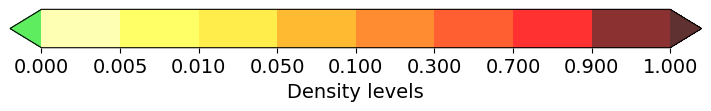

In [184]:
fig, ax = plt.subplots(figsize=(7, 1), layout='constrained')

colormap = plt.cm.YlOrRd
newColorMap = colormap(np.linspace(0, 1, 512))
newColorMap[0, :] = green
#newcmp = ListedColormap(newColorMap)

colormap = (mpl.colors.ListedColormap([green, lYelw, yelw, dYelw, lOrng, orng, dOrng, lred, Red, dRed]))
        #.with_extremes(under='yellow', over='magenta'))


bounds = [0, 0.005, 0.010, 0.05, 0.1, 0.3, 0.7, 0.9, 1]
norm = mpl.colors.BoundaryNorm(bounds, colormap.N, extend='both')
#norm = mpl.colors.LogNorm()#bounds[0], bounds[len(bounds)-1])
mappable = mpl.cm.ScalarMappable(cmap=newcmp, norm=norm)

cmap = mappable.get_cmap()

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=colormap),
             cax=ax, orientation='horizontal', label='Density levels')

plt.savefig('images/mapLegend.pdf', format="pdf", bbox_inches="tight")

In [129]:
def cColours(data):
    coloursMap = []
    for row in data:
        colours = []
        for col in row:
            if col == 0.0:
                colours.append(green)
            elif 0.0 < col < 0.005:
                colours.append(lYelw)
            elif 0.005 <= col < 0.015:
                colours.append(yelw)
            elif 0.015 <= col < 0.030:
                colours.append(dYelw)
            elif 0.030 <= col < 0.050:
                colours.append(lOrng)
            elif 0.050 <= col < 0.100:
                colours.append(orng)
            elif 0.100 <= col < 0.500:
                colours.append(dOrng)
            elif 0.500 <= col < 0.900:
                colours.append(lred)
            elif 0.900 <= col < 1:
                colours.append(Red)
            elif col == 1:
                colours.append(dRed)
            else:
                colours.append(white)
        coloursMap.append(colours)

    return coloursMap
    

<h3>Function to make map

In [195]:
def plotMap(data, dict):
    
    #mais tarde inverter as linhas com as colunas
    rows = ('chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX', 'chrY')
    cols = ["p34", "p33", "p32", "p31", "p30", "p29", "p28", "p27", "p26", "p25", "p24", "p23", "p22", "p21", "p20", "p19", "p18", "p17", "p16", "p15", "p14", "p13", "p12", "p11", "p10", "p09", "p08", "p07", "p06", "p05", "p04", "p03", "p02", "p01-centromer", "q01-centromer", "q02", "q03", "q04", "q05", "q06", "q07", "q08", "q09", "q10", "q11", "q12", "q13", "q14", "q15", "q16", "q17", "q18", "q19", "q20", "q21", "q22", "q23", "q24", "q25", "q26", "q27", "q28", "q29", "q30", "q31", "q32", "q33", "q34", "q35", "q36", "q37", "q38"]
    
    n_rows = len(data)
    n_cols = len(data[0])

    # Plot bars and create text labels for the table
    cell_text = []
    for row in rows:
        #string = "cytoband: " + str(dict[row][0]) + " density: " + str(dict[row][1])
        cell_text.append(dict[row])

    #Get some lists of color specs for row and column headers
    rcolors = plt.cm.BuPu(np.full(len(rows), 0.1))
    ccolors = plt.cm.BuPu(np.full(len(cols), 0.1))
    #cellcolours = plt.cm.YlOrRd(data)#.set_bad(color='white')         #coolwarm, Greys
    #cellcolours = cmap(data)
    cellcolours = cColours(data)
    
    plt.figure(linewidth=2,
           #edgecolor=fig_border,
           #facecolor=fig_background_color,
           tight_layout={'pad':1},
           figsize = (96,36),
          )
    
    the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      colLabels=cols,
                      rowLoc='right',
                      rowColours=rcolors,
                      colColours=ccolors,
                      cellColours=cellcolours,
                      loc='center')
    
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(11)
    the_table.scale(1.2, 10)
    # Hide axes
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Hide axes border
    plt.box(on=None)
    
    plt.draw()
    
    # Create image. plt.savefig ignores figure edge and face colors, so map them.
    fig = plt.gcf()
    plt.savefig('images/STR_density_in_human_genome.pdf', format="pdf", bbox_inches="tight")
    

<h3>Code for running the program

In [18]:
import warnings
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)

citoPath_read = "/home/androx/Documents/trabalho/citobands/cytobandFiltered_processed_complete.txt"
cb_df = pd.read_csv(citoPath_read, sep="\t")

dens_map = makeMap_dens(cb_df)
dict_map= makeMap_dict(cb_df)

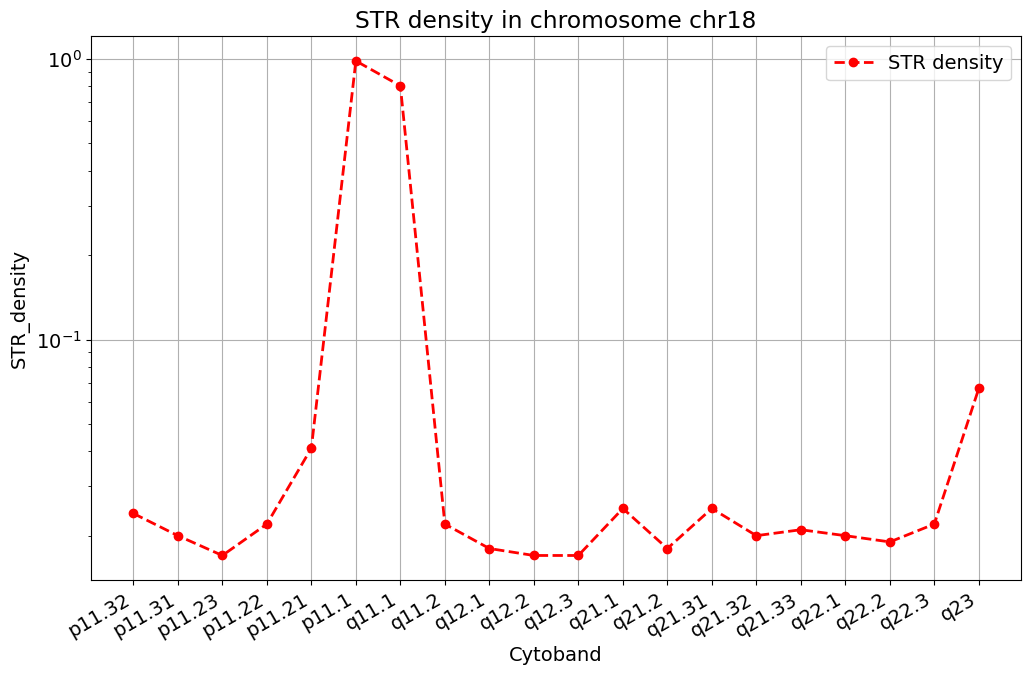

In [185]:
plot_1chr(cb_df, "chr18")

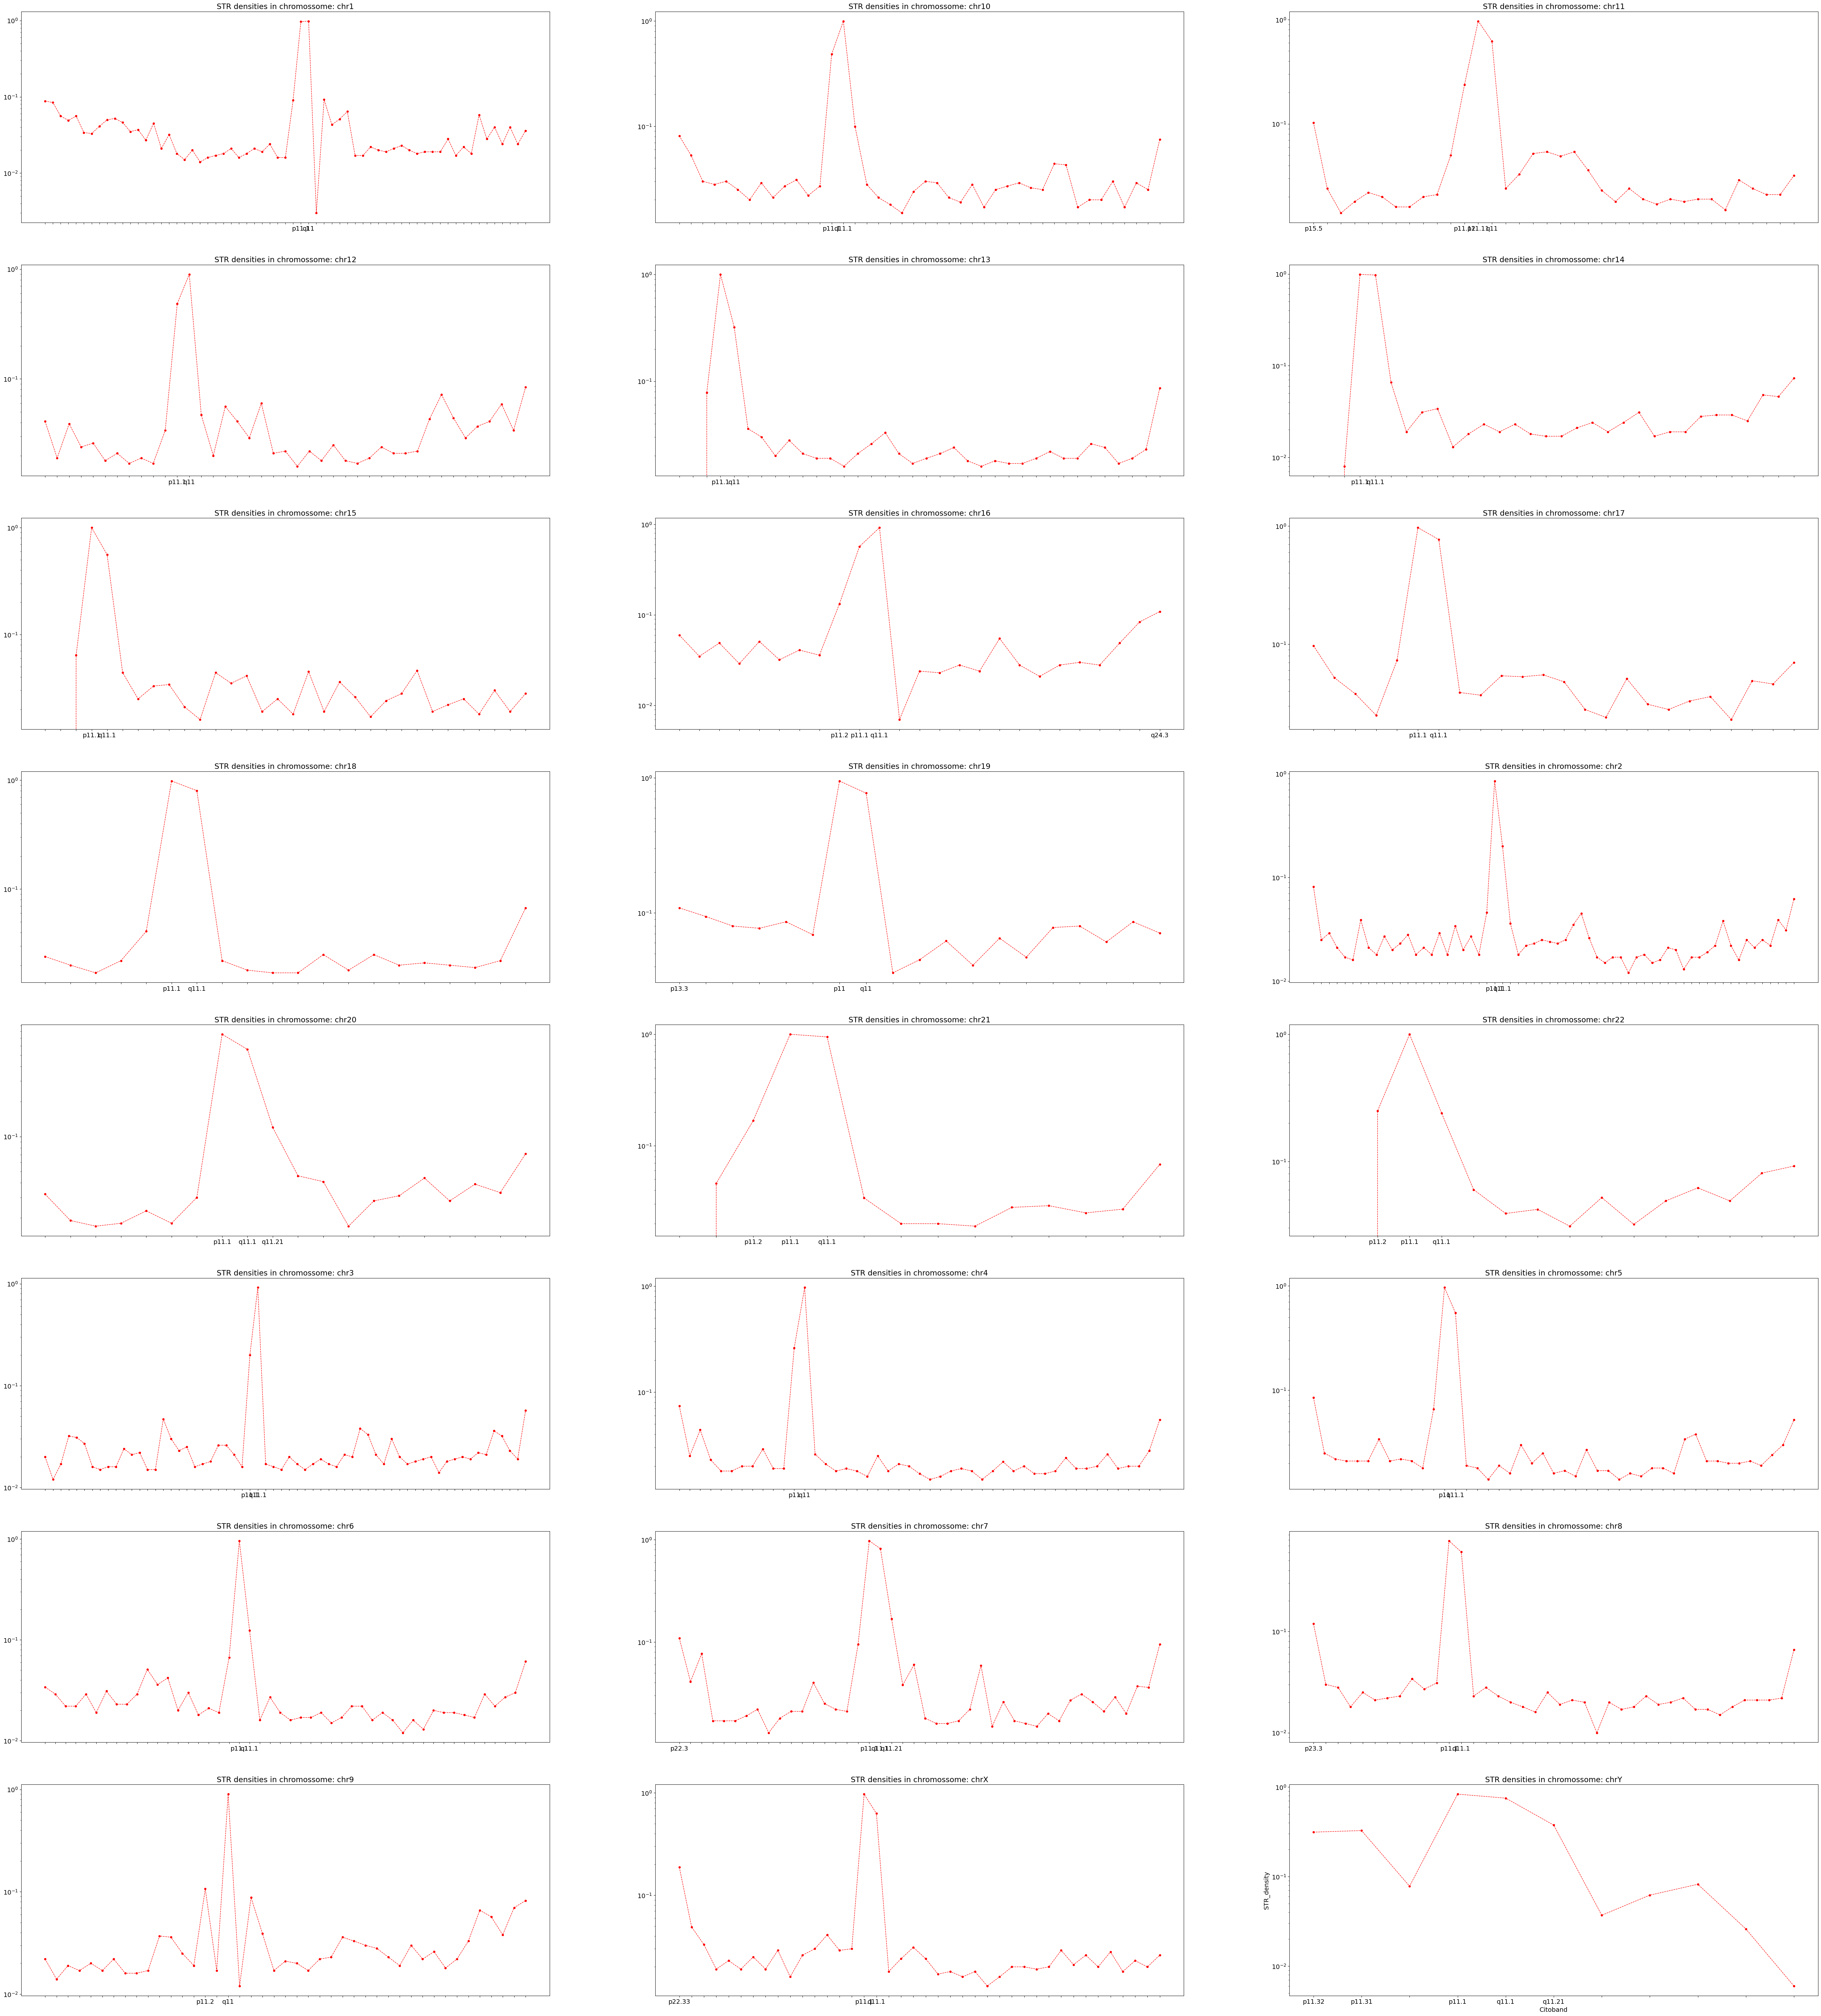

In [187]:
plotAll(cb_df)

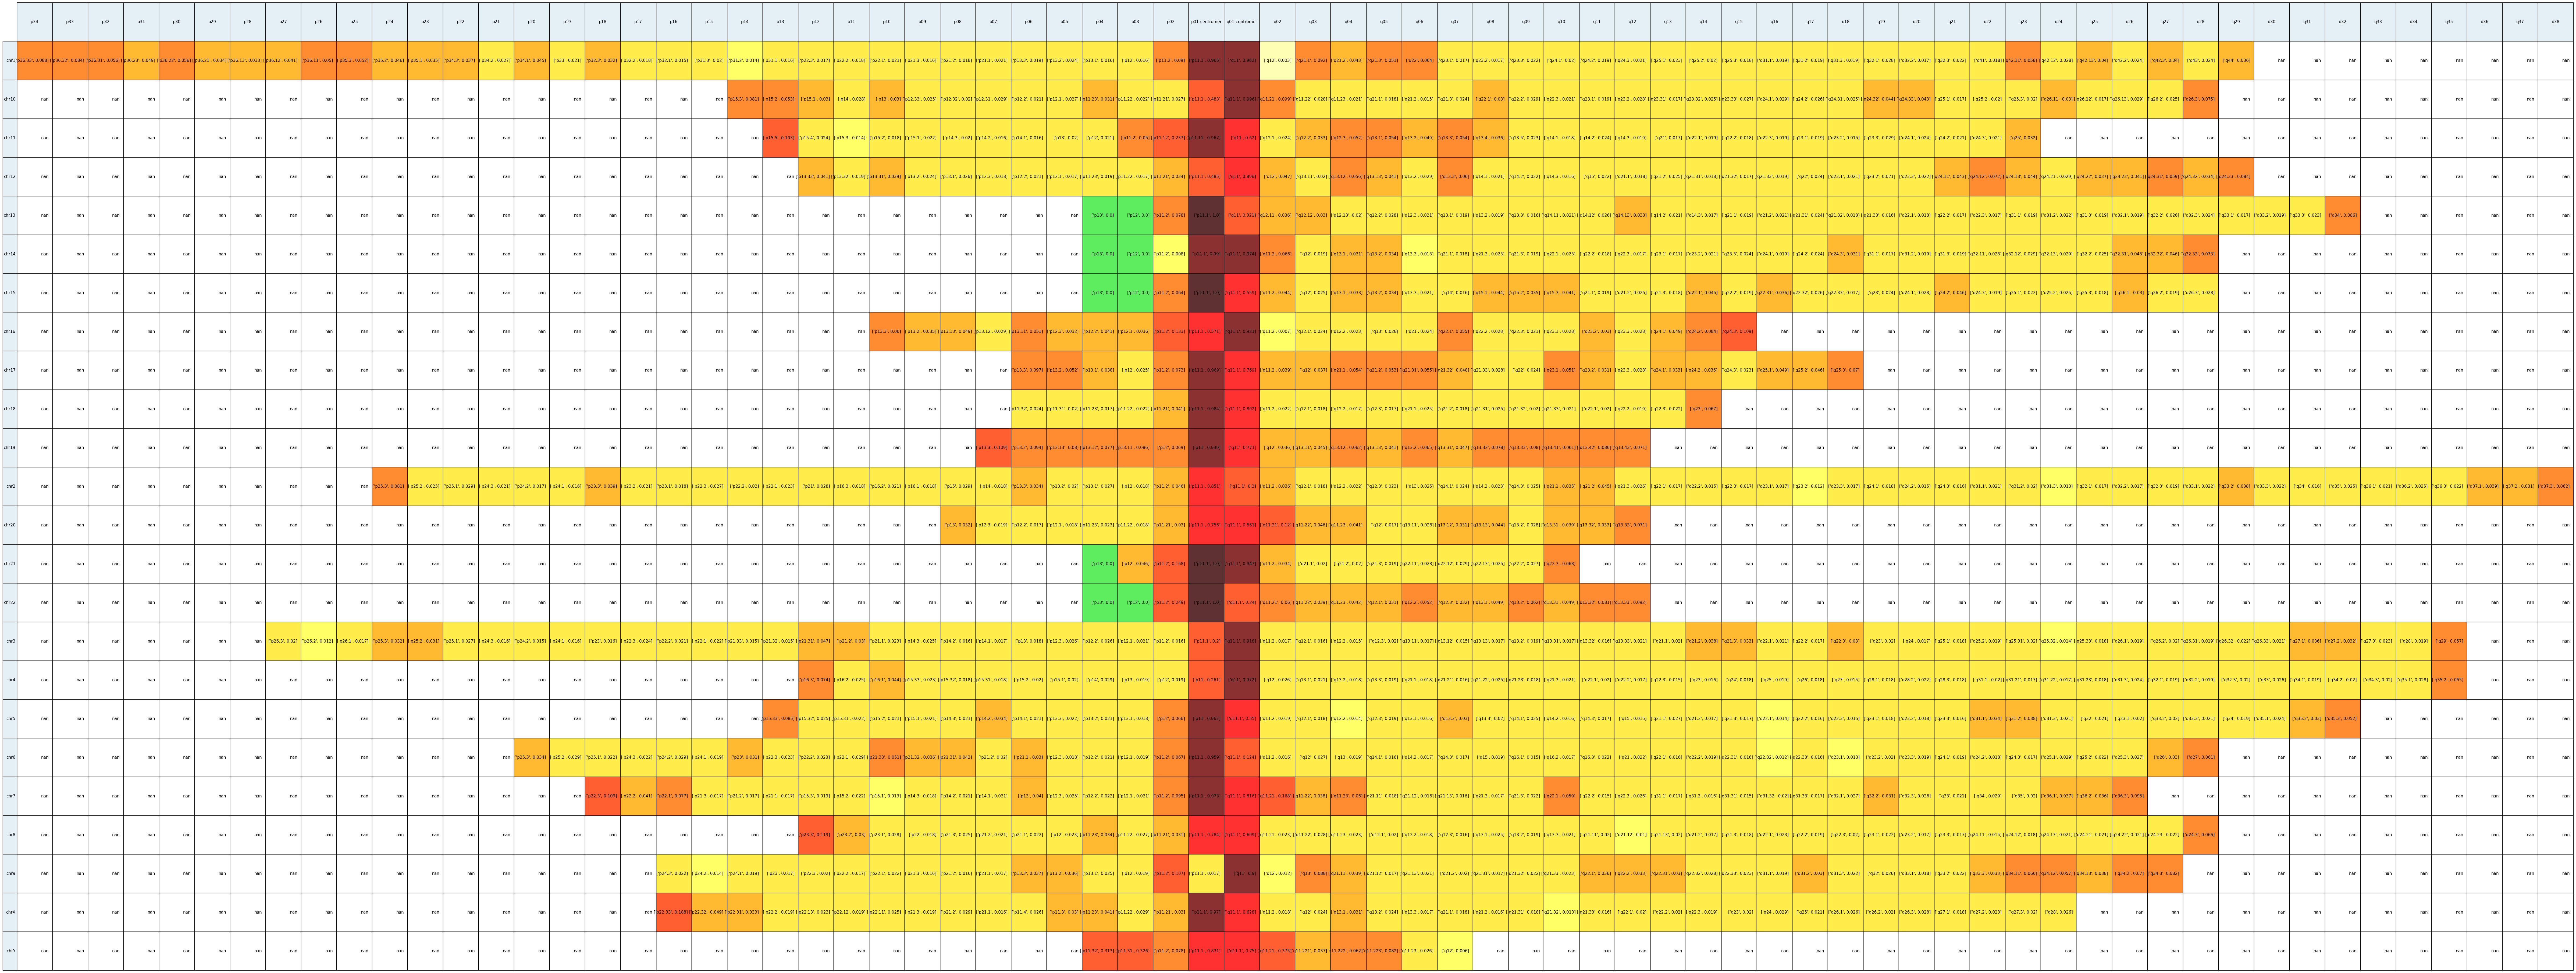

In [196]:
plotMap(dens_map, dict_map)